In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import modules

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

In [3]:
paths = []
labels = []

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split("_")[-1]
        label = label.split(".")[0]
        labels.append(label.lower())

    if len(paths) == 2800:
        break

print("Dataset is Loaded")

Dataset is Loaded


In [4]:
len(paths)

2800

In [5]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [6]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [7]:
# Create a dataframe
df = pd.DataFrame()

df['audio_paths'] = paths
df['labels'] = labels

df.head()

,audio_paths,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [8]:
df['labels'].value_counts()

labels
fear       400
angry      400
disgust    400
neutral    400
sad        400
ps         400
happy      400
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

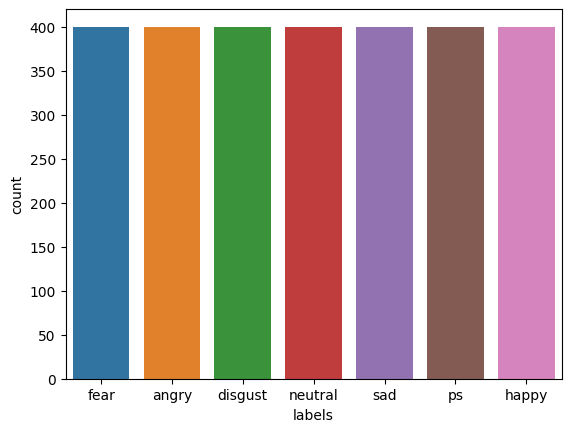

In [9]:
sns.countplot(data=df, x='labels')

In [10]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=28)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=28)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

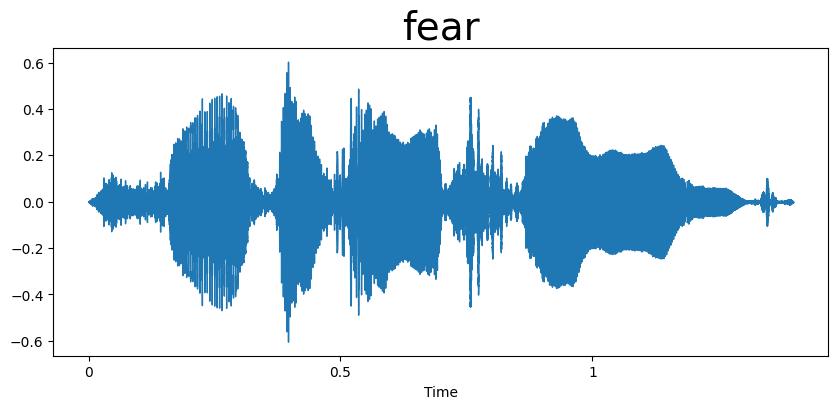

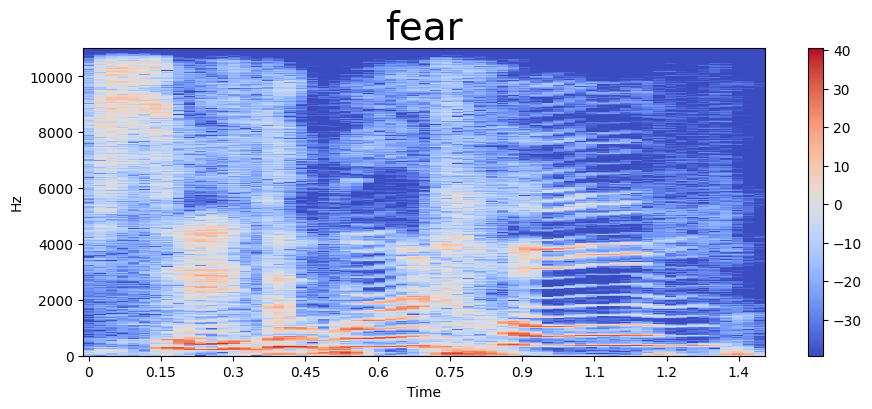

In [11]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

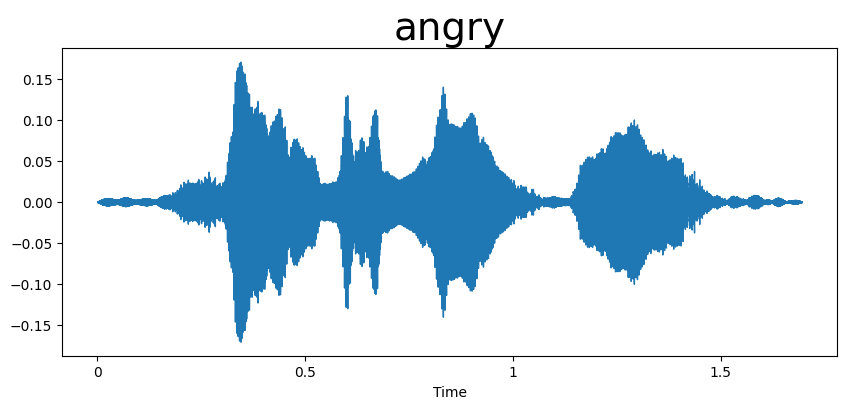

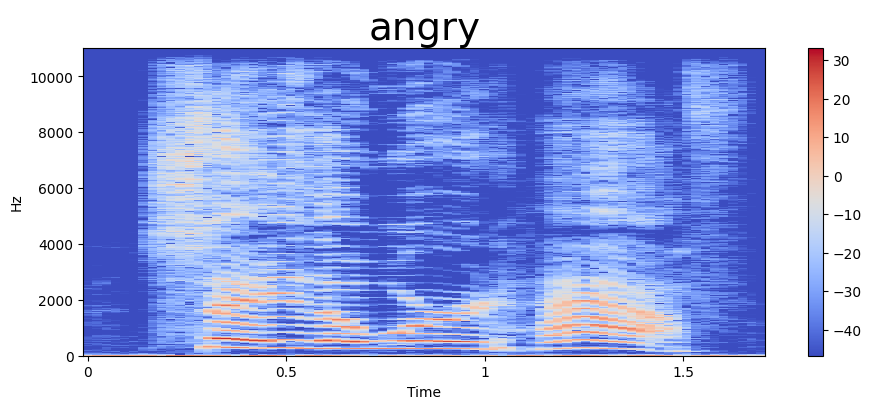

In [12]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels'] == emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

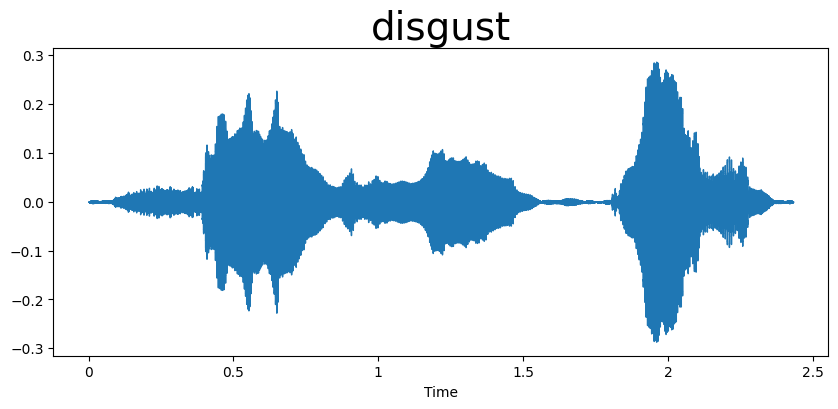

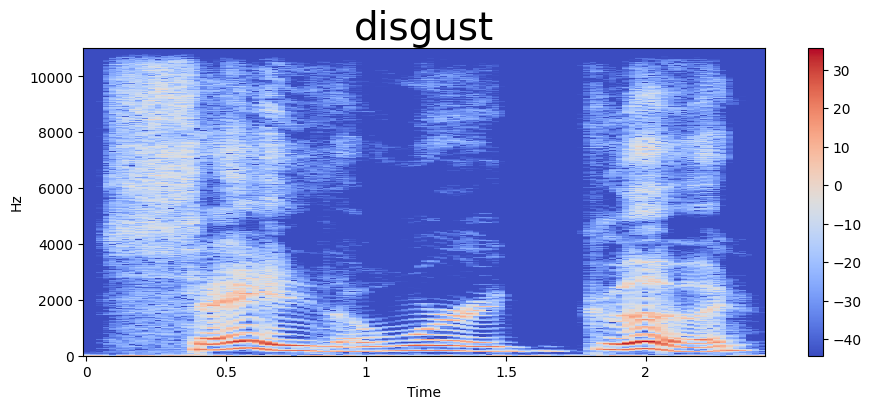

In [13]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


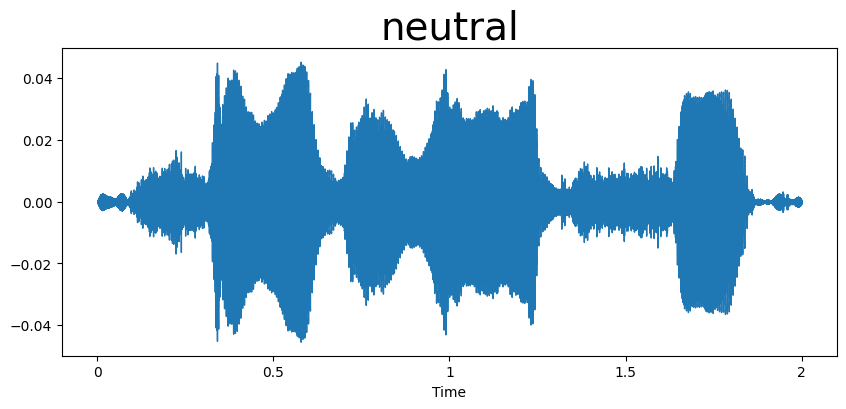

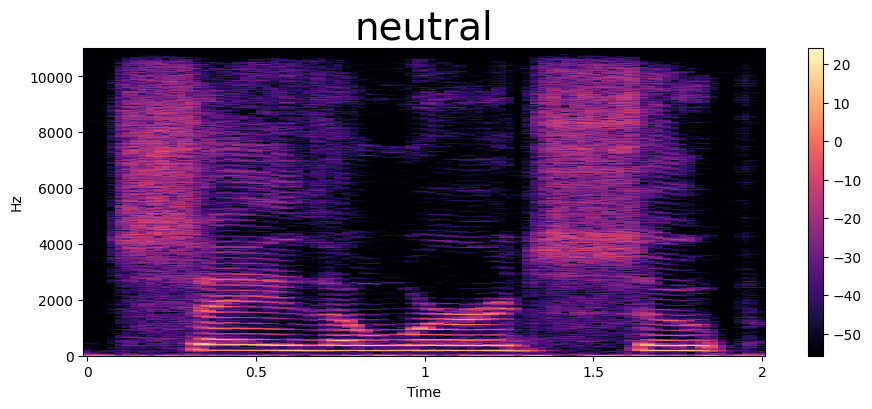

In [14]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

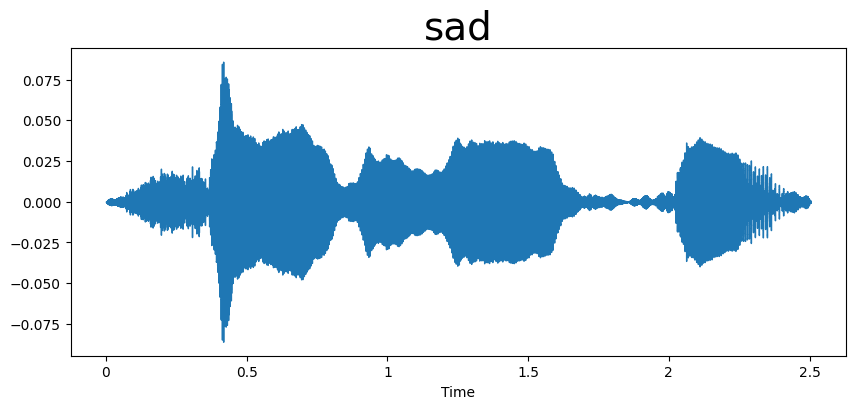

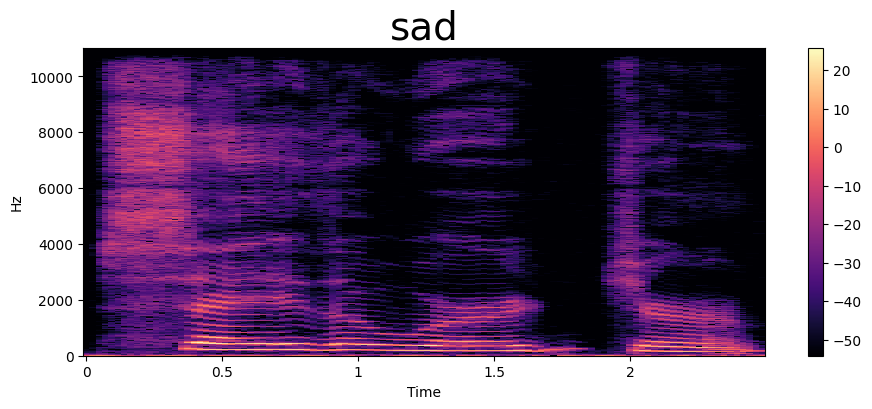

In [15]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

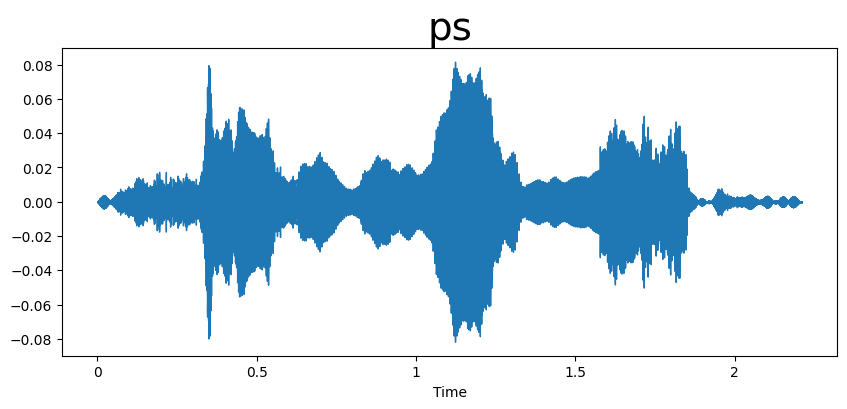

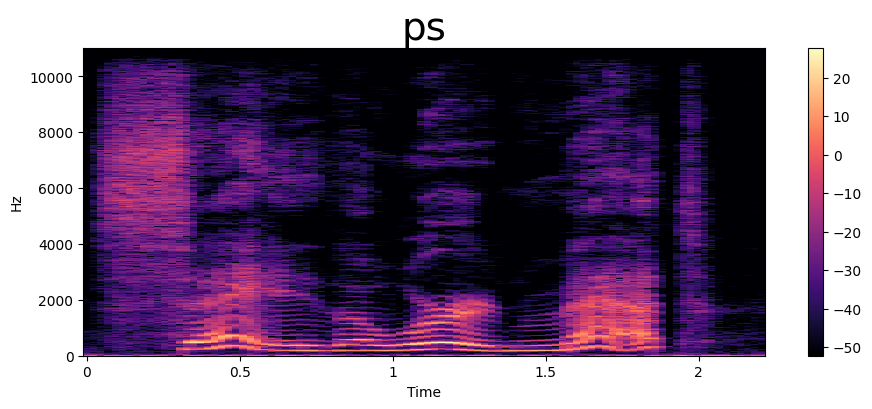

In [16]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

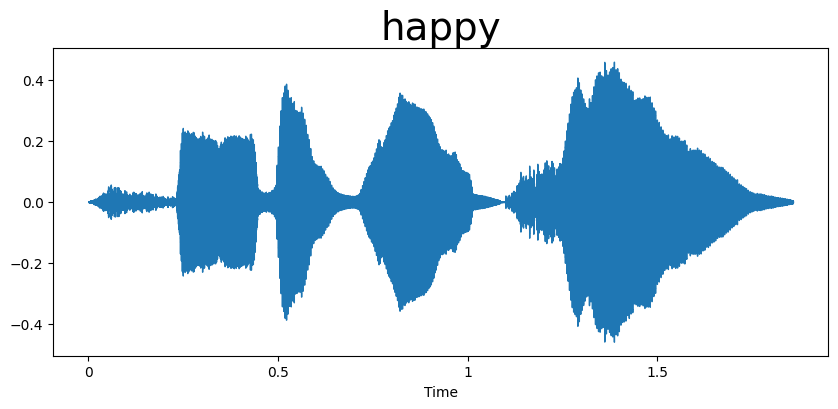

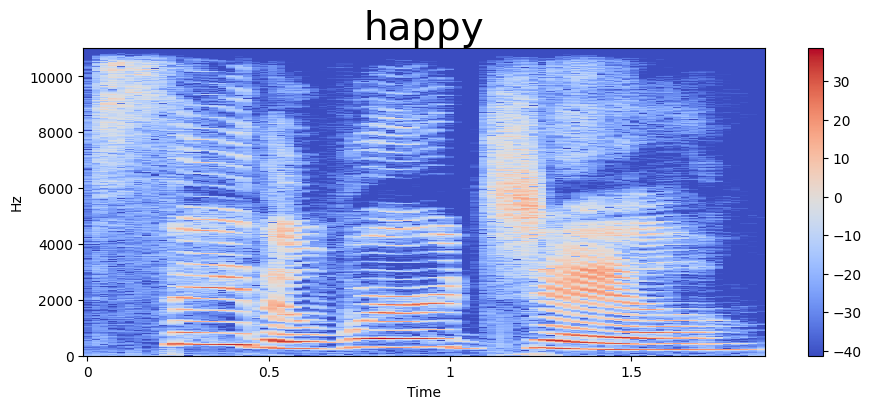

In [17]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [18]:
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}

df['labels'] = df['labels'].map(label_map)
df.head(2)

,audio_paths,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,0
1,/kaggle/input/toronto-emotional-speech-set-tes...,0


In [19]:
 # emotion = 'ps'
 # path = np.array(df['audio_paths'][df['labels']==2])[0]
 # data, sampling_rate = librosa.load(path)
 # len(data)
 # sampling_rate * 2

In [20]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label = self.df.iloc[idx]['labels']

    # Load the audio file
        speech, sr = librosa.load(audio_path, sr=16000)

    # Pad or truncate the speech to the required length
        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

    # Preprocess the audio file
        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()

        return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}

In [21]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [22]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

In [24]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

In [25]:
# Create Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

set training arguments

In [26]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids  # original labels
    preds = np.argmax(pred.predictions, axis=1)  # model predicted labels

    accuracy = accuracy_score(labels, preds)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [28]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.775646,0.907143,0.938640,0.907143,0.902267
2,No log,0.256195,1.000000,1.000000,1.000000,1.000000
3,No log,0.185089,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.7234288533528646, metrics={'train_runtime': 207.6154, 'train_samples_per_second': 32.368, 'train_steps_per_second': 2.023, 'total_flos': 1.2201848064e+17, 'train_loss': 0.7234288533528646, 'epoch': 3.0})

In [29]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.18508948385715485, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 4.6642, 'eval_samples_per_second': 120.063, 'eval_steps_per_second': 7.504, 'epoch': 3.0}


test predictionabs

In [30]:
import random

idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()

print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: disgust
Predicted Label: disgust


In [31]:
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()

print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: fear
Predicted Label: fear


In [32]:
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()

print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: disgust
Predicted Label: disgust


In [33]:
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()

print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: happy
Predicted Label: happy


In [34]:
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()

print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: angry
Predicted Label: angry


In [35]:
idx = random.randrange(0, len(test_dataset))

print("Original Label:", inverse_label_map[int(test_dataset[idx]['labels'])])

input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
    outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim=1).item()

print("Predicted Label:", inverse_label_map[predicted_class])

Original Label: happy
Predicted Label: happy


In [ ]:
exit()


In [1]:
pip install pipwin

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.5 MB/s eta 0:00:0000:01
  Created wheel for pipwin: filename=pipwin-0.5.2-py2.py3-none-any.whl size=8766 sha256=53fc7a2c0f3753deb858c5c43e74137544b34dc55342a5243c584f91bc254a5e
  Stored in directory: /root/.cache/pip/wheels/b4/2c/53/c5a91c548b9f030b592608c24efda23ff966b1cceac6414765
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=3c3d925e24a986bf56028dc8126cbbf7157681980ae96e1e280872955713e138
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25983 sha256=1320f58d07879952fea0cb439594d9f1ae2d6e57141b7de98d0bc1e7bf52d4e3
  Stored in directory: /root/.cache/pip/wheels/5e/81/26/5956478df303e2bf5a85a5df595bb307bd25948a4bab69f7c7
Successfu

In [2]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [3]:
pipwin install pyaudio


SyntaxError: invalid syntax (<ipython-input-3-b8d7c797a59c>, line 1)

In [4]:
import sounddevice as sd
import numpy as np

def record_audio(duration=5, sr=16000):
    """
    Record audio from the microphone for a specified duration.
    Args:
        duration (int): Duration to record in seconds.
        sr (int): Sampling rate of the audio.
    Returns:
        numpy.ndarray: Recorded audio signal.
    """
    print("Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()  # Wait until recording is finished
    print("Recording finished.")
    return audio.flatten()


OSError: PortAudio library not found

In [ ]:
def preprocess_audio(audio, processor, max_length=32000):
    """
    Preprocess the audio for Wav2Vec2 input.
    Args:
        audio (numpy.ndarray): Audio signal.
        processor: Wav2Vec2Processor.
        max_length (int): Maximum length of the audio input.
    Returns:
        torch.Tensor: Preprocessed audio input.
    """
    if len(audio) > max_length:
        audio = audio[:max_length]
    else:
        audio = np.pad(audio, (0, max_length - len(audio)), 'constant')

    inputs = processor(audio, sampling_rate=16000, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
    return inputs.input_values


In [ ]:
def predict_emotion(audio, model, processor, inverse_label_map):
    """
    Predict the emotion from the audio input.
    Args:
        audio (numpy.ndarray): Audio signal.
        model: Trained Wav2Vec2 model.
        processor: Wav2Vec2Processor.
        inverse_label_map (dict): Mapping from label indices to emotions.
    Returns:
        str: Predicted emotion.
    """
    input_values = preprocess_audio(audio, processor)
    input_values = input_values.to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(input_values)
        logits = outputs.logits
        predicted_class = logits.argmax(dim=1).item()
    
    return inverse_label_map[predicted_class]


In [ ]:
import pyttsx3

def respond_to_emotion(emotion):
    """
    Generate a response based on the detected emotion and speak it aloud.
    Args:
        emotion (str): Detected emotion.
    """
    responses = {
        "happy": "You sound cheerful! How can I assist you today?",
        "sad": "I'm here for you. Would you like to talk about anything?",
        "angry": "I sense some frustration. Let's work together to solve it.",
        "neutral": "You sound calm. What can I do for you?",
        # Add more emotion-specific responses as needed
    }

    response = responses.get(emotion, "I'm here to help. What can I do for you?")
    print("Assistant:", response)

    engine = pyttsx3.init()
    engine.say(response)
    engine.runAndWait()


In [ ]:
def voice_assistant_interaction(model, processor, inverse_label_map):
    """
    Record audio, detect emotion, and respond in real time.
    Args:
        model: Trained Wav2Vec2 model.
        processor: Wav2Vec2Processor.
        inverse_label_map (dict): Mapping from label indices to emotions.
    """
    while True:
        print("\nListening for your input...")
        audio = record_audio(duration=5)  # Record 5 seconds of audio

        emotion = predict_emotion(audio, model, processor, inverse_label_map)
        print(f"Detected Emotion: {emotion}")

        respond_to_emotion(emotion)


In [ ]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# Load trained model and processor
model_path = "./results"  # Path where your trained model is saved
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(model_path)
model.eval()  # Set the model to evaluation mode
model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Inverse label map for decoding predictions
inverse_label_map = {0: "neutral", 1: "happy", 2: "sad", 3: "angry"}  # Example mapping, update based on your labels
